# 3.17 Predicting House Prices on Kaggle

## 3.17.1 Kaggle

## 3.17.2 Accessing and Reading Data Sets

In [50]:
%matplotlib inline
import gluonbook as gb
from mxnet import autograd, gluon, init, nd
import mxnet as mx
from mxnet.gluon import data as gdata, loss as gloss
from mxnet.gluon import nn
import numpy as np
import pandas as pd

In [51]:
train_data = pd.read_csv('./kaggle_house_dataset/train.csv')
test_data = pd.read_csv('./kaggle_house_dataset/test.csv')

In [52]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


- Label: SalePrice

In [53]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [54]:
test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,2010,WD,Normal
1,1462,20,RL,81.0,2010,WD,Normal
2,1463,60,RL,74.0,2010,WD,Normal
3,1464,60,RL,78.0,2010,WD,Normal


- We remove the 'Id' column from the dataset before feeding the data into the network.

In [55]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [56]:
all_features.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,MSSubClass,MSZoning,LotFrontage,LotArea,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,2008,WD,Normal
1,20,RL,80.0,9600,2007,WD,Normal
2,60,RL,68.0,11250,2008,WD,Normal
3,70,RL,60.0,9550,2006,WD,Abnorml


## 3.17.3 Data Preprocessing

In [57]:
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


- Numerical features
  - 1) normalization
  - 2) fill the missing features with zero

In [58]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / (x.std()))
# after standardizing the data all means vanish, hence we can set missing values to 0
all_features = all_features.fillna(0)

- Discrete features
  - transform each feature into one-hot vector
  - this conversion increases the number of features from 79 to 354. 

In [59]:
# Dummy_na=True refers to a missing value being a legal eigenvalue, and creates 􏰀→ anindicativefeatureforit.
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

- We can extract the NumPy format from the Pandas dataframe
- Then, convert it into MXNet’s native representation - NDArray for training.

In [60]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

In [61]:
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)

(1460, 354)
(1460, 1)
(1459, 354)


## 3.17.4 Training

- linear model with squared loss

In [81]:
loss = gloss.L2Loss()

def get_net(model_type='linear'):
    if model_type == 'linear': 
        net = nn.Sequential()
        net.add(nn.Dense(1))
        net.initialize()
    else:
        net = nn.Sequential()
        net.add(
            nn.Dense(128, activation="relu"),
            nn.Dropout(0.5), 
            nn.Dense(48, activation="relu"),
            nn.Dropout(0.25),
            nn.Dense(1)
        )
        net.initialize(mx.init.Xavier())
    return net

- Getting a house price wrong by USD 100,000 is terrible in Rural Ohio
  - In Rural Ohio, the value of the house is USD 125,000. 
- In Los Altos Hills, California, we can be proud of the accuracy of our model 
  - The median house price there exceeds USD 4,000,000.
- One way to address this problem is to measure the discrepancy in the logarithm of the price estimates. 
- $|\log y - \log \hat{y}| < \delta $ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. 
- This leads to the following loss function:$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

In [82]:
def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the value less than 1 as 1.
    clipped_preds = nd.clip(
        data=net(features), 
        a_min=1, 
        a_max=float('inf')
    )
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

- The Adam optimization algorithm is relatively less sensitive to learning rates.

In [83]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(
        dataset=gdata.ArrayDataset(train_features, train_labels), 
        batch_size=batch_size, 
        shuffle=True
    )
    
    # The Adam optimization algorithm is used here.
    trainer = gluon.Trainer(
        params=net.collect_params(), 
        optimizer='adam', 
        optimizer_params={'learning_rate': learning_rate, 'wd': weight_decay}
    )
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## 3.17.5 k-Fold Cross-Validation

- We first need a function that returns the i-th fold of the data in a k-fold cros-validation procedure. 
  - It proceeds by slicing out the i-th segment as validation data and returning the rest as training data. 

In [84]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k  # floor division
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

- The training and verification error averages are returned when we train $k$ times in the k-fold cross-validation.

In [85]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(model_type="deep")
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            gb.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 3.17.6 Model Selection
- We pick a rather un-tuned set of hyperparameters and leave it up to the reader to improve the model considerably.

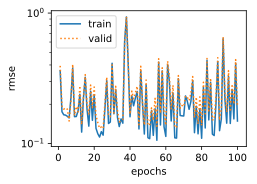

fold 0, train rmse: 0.148676, valid rmse: 0.193381
fold 1, train rmse: 0.198471, valid rmse: 0.242408
fold 2, train rmse: 0.257584, valid rmse: 0.299181
fold 3, train rmse: 0.274117, valid rmse: 0.271172
fold 4, train rmse: 0.215440, valid rmse: 0.250864
5-fold validation: avg train rmse: 0.218858, avg valid rmse: 0.251401


In [86]:
k = 5
num_epochs = 100
lr = 0.5
weight_decay = 5
batch_size = 64

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f' % (k, train_l, valid_l))

## 3.17.7 Predict and Submit

- Now that we know what a good choice of hyperparameters should be, we use all the data to train on it 

In [90]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(model_type="deep")
    train_ls, _ = train(
        net=net, 
        train_features=train_features, 
        train_labels=train_labels, 
        test_features=None, 
        test_labels=None, 
        num_epochs=num_epochs, 
        learning_rate=lr, 
        weight_decay=weight_decay, 
        batch_size=batch_size
    )
    gb.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    
    # apply the network to the test set
    preds = net(test_features).asnumpy()
    
    # reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission2.csv', index=False)

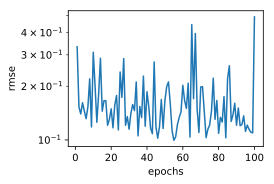

train rmse 0.489604


In [91]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)